## InceptionV3 w/ OASIS-1 dataset - Multiclass

##### Summary: this notebook is the InceptionV3 model with the OASIS 1 dataset using multiclass metrics.

#### Notebook setup

In [1]:
!pip install torchsummary
!pip install pytorch-lightning
!pip install lightning

# importing all necessary packages
import pandas as pd
import numpy as np
import cv2
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchmetrics
from torchmetrics.classification import BinaryF1Score
from torchsummary import summary

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning import Callback
from lightning.pytorch import loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

import os
from os import listdir
from os.path import join
import random

from PIL import Image

torch.set_float32_matmul_precision("high")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.3/802.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 12.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-many

In [2]:
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [3]:
import zipfile
import os

# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')


# Path to the zip file in Google Drive
zip_path = '/content/drive/My Drive/CS231N/Final_Project/archive.zip'

# Temporary directory where you want to unzip the files
unzip_dir = '/content/OASIS_1_dataset'

# Create a directory if it doesn't exist
os.makedirs(unzip_dir, exist_ok=True)

# Unzipping the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

print(f'Unzipped the files in {unzip_dir}')
mri_image_path = '/content/OASIS_1_dataset/Curated OASIS/'


Mounted at /content/drive
Unzipped the files in /content/OASIS_1_dataset


#### Visualizing a few MRI scans

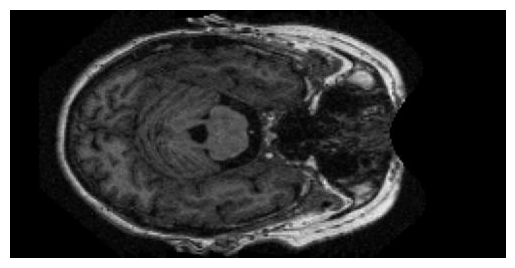

In [4]:
# Load an image from Healthy
sample_image_path = mri_image_path + 'Train/label_Healthy/OAS1_0001_MR1_mpr-1_100.jpg'
img = Image.open(sample_image_path)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

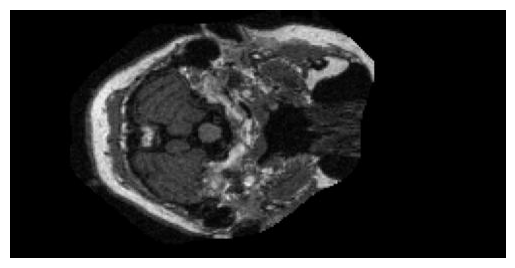

In [5]:
# Load an image from VeryMild
sample_image_path = mri_image_path + 'Train/label_VeryMild/OAS1_0003_MR1_mpr-1_100.jpg'
img = Image.open(sample_image_path)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

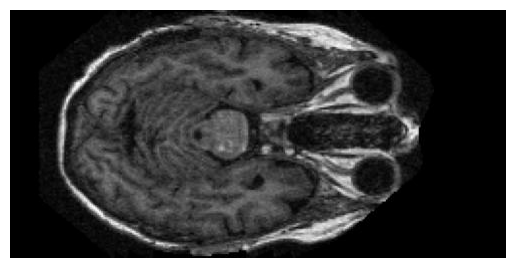

In [6]:
# Load an image from MildModerate
sample_image_path = mri_image_path + 'Train/label_MildModerate/OAS1_0028_MR1_mpr-1_112.jpg'
img = Image.open(sample_image_path)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

#### Data Preparation

In [7]:
# Getting the total number of images under each label:
def count_categories(subsets):
  # Categories you are interested in
  categories = ['label_Healthy', 'label_MildModerate', 'label_VeryMild']

  # Function to count JPG files
  def count_jpg_files(directory):
      count = 0
      for root, dirs, files in os.walk(directory):
          count += sum(1 for file in files if file.lower().endswith('.jpg'))
      return count

  # Counting JPG files in each category across all sets
  total_counts = {category: 0 for category in categories}
  for category in categories:
      # Include counts from Train, Validation, and Test
      for subset in subsets:
          path = os.path.join(mri_image_path, subset, category)
          total_counts[category] += count_jpg_files(path)

  # Display the total counts
  for category, count in total_counts.items():
      print(f"Total JPGs in {category}: {count}")

count_categories(['Train', 'Test', 'Validation']) # This is counting across all the subsets

Total JPGs in label_Healthy: 67222
Total JPGs in label_MildModerate: 5490
Total JPGs in label_VeryMild: 13725


In [8]:
# Drilling in deeper - per train, val, test:

print('For Train:')
count_categories(['Train'])
print('For Validation:')
count_categories(['Validation'])
print('For Test:')
count_categories(['Test'])

For Train:
Total JPGs in label_Healthy: 47336
Total JPGs in label_MildModerate: 3843
Total JPGs in label_VeryMild: 9455
For Validation:
Total JPGs in label_Healthy: 13298
Total JPGs in label_MildModerate: 1159
Total JPGs in label_VeryMild: 3050
For Test:
Total JPGs in label_Healthy: 6588
Total JPGs in label_MildModerate: 488
Total JPGs in label_VeryMild: 1220


In [9]:
# def augment_datasets(label, min_count=12000):
#   # Define the directory containing your images
#   data_dir = os.path.join(mri_image_path, label)

#   # Define categories and target counts
#   categories = ['label_Healthy', 'label_VeryMild', 'label_MildModerate']

#   # Augmentation pipeline
#   augment_transforms = transforms.Compose([
#       transforms.RandomRotation(20),
#       transforms.RandomHorizontalFlip(),
#       transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
#       transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)
#   ])

#   def augment_images(category, num_needed):
#       category_path = os.path.join(data_dir, category)
#       # augmented_images_path = os.path.join(category_path, 'augmented')
#       # os.makedirs(augmented_images_path, exist_ok=True)
#       images = [os.path.join(category_path, f) for f in os.listdir(category_path) if f.endswith('.jpg')]

#       i = 0
#       while i < num_needed:
#           for img_path in images:
#               if i >= num_needed:
#                   break
#               img = Image.open(img_path).convert('RGB')
#               augmented_img = augment_transforms(img)
#               augmented_img.save(os.path.join(category_path, f'aug_{i}_{os.path.basename(img_path)}'))
#               i += 1
#       print(f'Saved {i} augmented images in {category_path}', end='\r')

#   # Determine how many images to augment for each category
#   for category in categories:
#       category_path = os.path.join(data_dir, category)
#       current_count = len([name for name in os.listdir(category_path) if name.endswith('.jpg')])
#       if current_count < min_count:
#           print(f'Augmenting for {category}')
#           augment_needed = min_count - current_count
#           augment_images(category, augment_needed)


# augment_datasets('Train')
# count_categories()

In [10]:
folders = ['label_Healthy', 'label_VeryMild', 'label_MildModerate']

def get_data(path, folders, max_samples_per_category=None):
    pathname_list, labels = [], []
    # Gather file paths and labels
    for folder in folders:
        folder_path = join(path, folder)
        print(folder_path)
        files = [f for f in listdir(folder_path) if not f.startswith('.')]
        # Optionally limit the number of files to include from each folder
        if max_samples_per_category:
            random.shuffle(files)  # Shuffle before slicing to randomize the files selected
            files = files[:max_samples_per_category]
        # Extend lists with the new data
        pathname_list.extend(join(folder_path, f) for f in files)
        labels.extend(folder for _ in files)

    # Shuffle the lists
    random.seed(RANDOM_SEED)  # Set the random seed for reproducibility
    combined = list(zip(pathname_list, labels))
    random.shuffle(combined)

    # Unzip the combined list back into two lists
    pathname_list, labels = zip(*combined)

    return pathname_list, labels

max_samples = 20000  # Set the cap for samples per category for training and validation

# Applying the cap to training and validation datasets
X_train_path, y_train = get_data(join(mri_image_path, 'Train'), folders, max_samples)
X_val_path, y_val = get_data(join(mri_image_path, 'Validation'), folders)
X_test_path, y_test = get_data(join(mri_image_path, 'Test'), folders)  # No cap for test data


/content/OASIS_1_dataset/Curated OASIS/Train/label_Healthy
/content/OASIS_1_dataset/Curated OASIS/Train/label_VeryMild
/content/OASIS_1_dataset/Curated OASIS/Train/label_MildModerate
/content/OASIS_1_dataset/Curated OASIS/Validation/label_Healthy
/content/OASIS_1_dataset/Curated OASIS/Validation/label_VeryMild
/content/OASIS_1_dataset/Curated OASIS/Validation/label_MildModerate
/content/OASIS_1_dataset/Curated OASIS/Test/label_Healthy
/content/OASIS_1_dataset/Curated OASIS/Test/label_VeryMild
/content/OASIS_1_dataset/Curated OASIS/Test/label_MildModerate


In [11]:
# Check Train set
print("Train Set")
print(len(X_train_path), len(y_train))
print(X_train_path[-5:])
print(y_train[-5:])

# Check Validation set
print("Validation Set")
print(len(X_val_path), len(y_val))
print(X_val_path[-5:])
print(y_val[-5:])

# Check Test set
print("Test Set")
print(len(X_test_path), len(y_test))
print(X_test_path[-5:])
print(y_test[-5:])

Train Set
33298 33298
('/content/OASIS_1_dataset/Curated OASIS/Train/label_Healthy/OAS1_0080_MR2_mpr-4_151.jpg', '/content/OASIS_1_dataset/Curated OASIS/Train/label_Healthy/OAS1_0051_MR1_mpr-2_101.jpg', '/content/OASIS_1_dataset/Curated OASIS/Train/label_Healthy/OAS1_0145_MR1_mpr-1_144.jpg', '/content/OASIS_1_dataset/Curated OASIS/Train/label_Healthy/OAS1_0009_MR1_mpr-3_101.jpg', '/content/OASIS_1_dataset/Curated OASIS/Train/label_Healthy/OAS1_0091_MR1_mpr-4_147.jpg')
('label_Healthy', 'label_Healthy', 'label_Healthy', 'label_Healthy', 'label_Healthy')
Validation Set
17507 17507
('/content/OASIS_1_dataset/Curated OASIS/Validation/label_Healthy/OAS1_0102_MR1_mpr-1_153.jpg', '/content/OASIS_1_dataset/Curated OASIS/Validation/label_Healthy/OAS1_0017_MR1_mpr-3_106.jpg', '/content/OASIS_1_dataset/Curated OASIS/Validation/label_Healthy/OAS1_0065_MR1_mpr-1_112.jpg', '/content/OASIS_1_dataset/Curated OASIS/Validation/label_Healthy/OAS1_0086_MR1_mpr-1_142.jpg', '/content/OASIS_1_dataset/Curated

In [12]:
# Count the occurrences of each label
def count_labels(labels_list):

    healthy_count = labels_list.count('label_Healthy')
    vmild_count = labels_list.count('label_VeryMild')
    mildmod_count = labels_list.count('label_MildModerate')

    # Calculate the percentages
    total_count = len(labels_list)
    healthy_percentage = (healthy_count / total_count) * 100
    vmild_percentage = (vmild_count / total_count) * 100
    mildmod_percentage = (mildmod_count / total_count) * 100

    # Print the results
    print(f"'healthy_percentage' percentage: {healthy_percentage:.2f}%")
    print(f"'vmild_percentage' percentage: {vmild_percentage:.2f}%")
    print(f"'mildmod_percentage' percentage: {mildmod_percentage:.2f}%")

print("Train set:")
count_labels(y_train)

print("Validation set:")
count_labels(y_val)

print("Test set:")
count_labels(y_test)

Train set:
'healthy_percentage' percentage: 60.06%
'vmild_percentage' percentage: 28.40%
'mildmod_percentage' percentage: 11.54%
Validation set:
'healthy_percentage' percentage: 75.96%
'vmild_percentage' percentage: 17.42%
'mildmod_percentage' percentage: 6.62%
Test set:
'healthy_percentage' percentage: 79.41%
'vmild_percentage' percentage: 14.71%
'mildmod_percentage' percentage: 5.88%


In [13]:
# Encode Labels (Y) to numerical values

# Define the mapping
label_mapping = {'label_Healthy': 0, 'label_VeryMild': 1, 'label_MildModerate': 2}

# Use map to apply the mapping
y_train_encoded = list(map(lambda x: label_mapping[x], y_train))
y_val_encoded = list(map(lambda x: label_mapping[x], y_val))
y_test_encoded = list(map(lambda x: label_mapping[x], y_test))

#### Creating OASIS1MRIDataset from JPG image paths

In [14]:
class OASIS1MRIDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.image_path = X
        self.label = y
        self.transform = transform

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, idx):
        image = Image.open(self.image_path[idx])
        image = self.transform(image)
        targets = self.label[idx]
        return image.float(), torch.tensor(targets)

    def show_transforms(self, idx):
        image = Image.open(self.image_path[idx])
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        transformed_image = self.transform(image)
        # Convert tensor to image for display
        transformed_image = transformed_image.permute(1, 2, 0)  # Change from CxHxW to HxWxC
        transformed_image = transformed_image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        transformed_image = transformed_image.clamp(0, 1)
        plt.imshow(transformed_image)
        plt.title('Transformed Image')
        plt.show()

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

default_val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Creating Train, Validation, and Test Datasets

train_dataset = OASIS1MRIDataset(X_train_path, y_train_encoded, train_transforms)
val_dataset = OASIS1MRIDataset(X_val_path, y_val_encoded, default_val_test_transform)
test_dataset = OASIS1MRIDataset(X_test_path, y_test_encoded, default_val_test_transform)

# train_dataset.show_transforms(50)
# val_dataset.show_transforms(50)
# test_dataset.show_transforms(50)

In [15]:
# Creating Train, Validation, and Test Dataloaders

def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=128, num_workers=10):
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=10)
  valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=10)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=10)
  return train_loader, valid_loader, test_loader

train_loader, valid_loader, test_loader = create_dataloaders(train_dataset, val_dataset, test_dataset)

#### Creating ShuffleNetV2 Model Architecture and running model

In [16]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.classification import BinaryAccuracy
import torchmetrics

class BaseNet(pl.LightningModule):
    def __init__(self, model, learning_rate, num_classes):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.num_classes = num_classes



         # Define loss function with class weights (to address class imbalance)
        self.class_weights = self.compute_class_weights()  # Compute class weights
        self.ce_loss = nn.CrossEntropyLoss(weight=self.class_weights) # Loss function

        # Multiclass metrics to collect
        self.accuracy = BinaryAccuracy()
        self.balanced_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes, average='macro')

        # AUROC Metrics - Multiclass classification, Weighted average due to class imbalance
        self.mlc_auroc = torchmetrics.AUROC(task="multiclass", num_classes=num_classes, average="weighted")
        self.save_hyperparameters()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        preds = torch.argmax(logits, dim=1)
        # Calculate CE Loss
        loss = self.ce_loss(logits, y)
        self.log('train_loss', loss)

        # Calculating regular accuracy
        binary_preds = (preds == y).int()
        all_ones = torch.ones_like(binary_preds)
        acc = self.accuracy(binary_preds, all_ones)
        self.log('train_acc', acc, prog_bar=True)

        # Calculating balanced accuracy
        train_bac = self.balanced_accuracy(logits, y)
        self.log('train_bac', train_bac)

        # Calculating AUROC
        y_hat = F.softmax(logits, dim=1)  # Apply softmax to normalise logits
        auroc = self.mlc_auroc(y_hat, y)   # calculate auroc
        self.log('train_auroc', auroc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        preds = torch.argmax(logits, dim=1)
        # Calculate CE Loss
        loss = self.ce_loss(logits, y)
        self.log('val_loss', loss)

        # Calculating regular accuracy
        binary_preds = (preds == y).int()
        all_ones = torch.ones_like(binary_preds)
        acc = self.accuracy(binary_preds, all_ones)
        self.log('val_acc', acc, prog_bar=True)

        # Calculating balanced accuracy
        balanced_accuracy = self.balanced_accuracy(logits, y)
        self.log('val_bac', balanced_accuracy)

        # Calculating AUROC
        y_hat = F.softmax(logits, dim=1)
        auroc = self.mlc_auroc(y_hat, y)
        self.log('val_auroc', auroc, prog_bar=True)


    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        preds = torch.argmax(logits, dim=1)
        probs = F.softmax(logits, dim=1)

        # Calculate CE Loss
        loss = self.ce_loss(logits, y)
        self.log('test_loss', loss)

        # Calculating regular accuracy
        binary_preds = (preds == y).int()
        all_ones = torch.ones_like(binary_preds)
        acc = self.accuracy(binary_preds, all_ones)
        self.log('test_acc', acc, prog_bar=True)

        # Calculated balanced accuracy
        bac = self.balanced_accuracy(preds, y)
        self.log('test_bac', bac, prog_bar=True)

        # Calculate AUROC
        y_hat = F.softmax(logits, dim=1)
        auroc = self.mlc_auroc(y_hat, y)
        self.log('test_auroc', auroc, prog_bar=True)
        return {
            'test_loss': loss,
            'test_acc': acc,
            'test_bac': bac,
            'test_auroc': auroc
        }

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def compute_class_weights(self):
      class_counts = [265, 58, 23]  # Example counts
      total_samples = sum(class_counts)
      class_weights = [total_samples / (len(class_counts) * count) for count in class_counts]
      return torch.tensor(class_weights, dtype=torch.float32)

In [ ]:
from torchvision.models import inception_v3, Inception_V3_Weights

class ModifiedInceptionResNet(BaseNet):
    def __init__(self, learning_rate, num_classes):
        weights = Inception_V3_Weights.DEFAULT
        model = inception_v3(weights=weights)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        super().__init__(model, learning_rate, num_classes)

# instantiate the model
model = ModifiedInceptionResNet(learning_rate=1e-4, num_classes=3)  # multiclass classification: num_class = 3

# Define a checkpoint callback to save the best model based on validation F1 score
checkpoint_callback = ModelCheckpoint(
    monitor='val_auroc',
    mode='max',
    save_top_k=1,
    dirpath='InceptionV3MC/checkpoint/'
)

# Perform early stopping by tracking improvement in validation accuracy score
early_stop_callback = EarlyStopping(
    monitor='val_acc',   # monitor validation acc
    min_delta=0.001,
    patience=2,           # stop if no improvement after 2 epochs
    verbose=True,
    mode='max'
)

# Training
logger = TensorBoardLogger("lightning_logs/", name="InceptionV3MC", version="v0.1", log_graph=True)

trainer = pl.Trainer(max_epochs=10, logger=logger, callbacks=[checkpoint_callback, early_stop_callback], log_every_n_steps=10)
model.example_input_array = torch.randn(1, 3, 224, 224)

#train the model
trainer.fit(model, train_loader, valid_loader)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 176MB/s]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerator

In [ ]:
#  Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

In [ ]:
# Run the best model using the test data
best_model_path = checkpoint_callback.best_model_path
results = trainer.test(ckpt_path=best_model_path, dataloaders=test_loader)
# Results: [{'test_loss': 0.9090562462806702, 'test_auroc': 0.8260954022407532}]

#### Creating Model metrics and figures

In [ ]:
print(results)

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(model, test_loader, class_names, percentage=False):
    # Ensure the model is in evaluation mode and on the correct device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            logits = model(inputs)
            logits_norm = F.softmax(logits, dim=1)
            predicted = torch.argmax(logits_norm, dim=1)  # Predicted class labels
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if percentage:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize confusion matrix
        fmt = ".2f"
        title = 'Confusion Matrix (%)'
    else:
        fmt = "d"
        title = 'Confusion Matrix'

    # Plotting
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)
    plt.show()

class_names = ['label_Healthy', 'label_VeryMild', 'label_MildModerate']
plot_confusion_matrix(model, test_loader, class_names, percentage=False)  # For absolute counts
plot_confusion_matrix(model, test_loader, class_names, percentage=True)   # For percentages
